In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import numbers
import re
import seaborn as sns
from collections import defaultdict
def ppoints(n, a=None):
	""" numpy analogue or `R`'s `ppoints` function
		see details at https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/ppoints
		https://docs.tibco.com/pub/enterprise-runtime-for-R/5.0.0/doc/html/Language_Reference/stats/ppoints.html
		:param n: array type or number"""
	
	if isinstance(n, numbers.Number):
		n = np.float(n)
	else:
		n = np.float(len(n))
	if a == None:
		a = .375 if n<=10 else .5
		a
	return (np.arange(n) + 1 - a)/(n + 1 - 2*a)

def getChromLabelPos(df):
    minDf = df.groupby('Chromosome').min()['Position ']
    maxDf = df.groupby('Chromosome').max()['Position ']
    chromLabelDf = pd.DataFrame()
    chromLabelDf['min'] = minDf
    chromLabelDf['max'] = maxDf
    
    maxList = chromLabelDf['max'].to_list()
    maxList.pop()
    fList = [0] + maxList
    chromLabelDf['maxBase'] = fList
    chromLabelDf['cumSum'] = np.cumsum(chromLabelDf['maxBase'])
    
    #minDf = df.groupby('Chromosome').min()['cumSum']
    #maxDf = df.groupby('Chromosome').max()['cumSum']
    chromLabelDf['mid'] = ((chromLabelDf['min'] + chromLabelDf['max'])/2) + chromLabelDf['cumSum']
    return chromLabelDf





def get_ManhattanPot_pair(df, axs, title, alpha=0.6, colors=['#A3A3A3','#312F2F'],size=10):

    dfSample = df.sort_values(['Chromosome', 'Position '], ignore_index=True)
    dfPos = getChromLabelPos(dfSample)
    dfSample = dfSample.merge(dfPos[['cumSum']], on='Chromosome')
    dfSample['cumPos'] = dfSample['Position '] + dfSample['cumSum']


    pvalue = 'P.value'

    #Manhattan plot
    axs[0].grid(axis='y')
    base = 0


    i = 0
    for chrom, sdf in dfSample.groupby(['Chromosome']):
        if i % 2 == 0:
            axs[0].scatter(x = sdf['cumPos'], y=-np.log10(sdf[pvalue]), marker='o',c=colors[0],rasterized=True,alpha=alpha,s=size)
        else:
            axs[0].scatter(x = sdf['cumPos'], y=-np.log10(sdf[pvalue]), marker='o',c=colors[1],rasterized=True,alpha=alpha,s=size)
        i += 1



    xTicks = dfPos['mid'].to_list() 

    axs[0].set_xticks(xTicks)
    axs[0].set_xticklabels(['$%s$' % x for x in dfSample['Chromosome'].unique()], size=15)


    axs[0].set_ylabel("$-log_{10}(p)$",fontsize=15)
    #FDR threshold

    dfSample = dfSample.sort_values(pvalue)
    dfSample['ind'] = range(1,dfSample.shape[0]+1) 

    #Bonferroni threshold
    bonferroni_threshold = -np.log10(0.05/dfSample.shape[0])
    axs[0].plot([0,dfSample['cumPos'].max()],[bonferroni_threshold,bonferroni_threshold],'r--')


    #Annotate overBonferroni SNPs
    annotSNPs = dfSample[-np.log10(dfSample[pvalue]) > bonferroni_threshold]
    text = list()
    lims = axs[0].dataLim


    for i, row in annotSNPs.iterrows():
        nx = row['cumPos']/(lims.intervalx[1] - lims.intervalx[0])
        ny = -np.log10(row[pvalue])/(lims.intervaly[1] - lims.intervaly[0])
        #text.append(plt.text(row['cumPos'], -np.log10(row[pvalue]), row['SNP']))

    #adjust_text(text,ax=axs,only_move={'text':'y', 'points':''})
    axs[0].set_title(title, size=24)


    #qqplot
    axs[1].grid(axis='y')
    observed = -np.log10(np.sort(dfSample[pvalue]))
    expected = -np.log10(ppoints(dfSample.shape[0]))
    axs[1].scatter(expected,observed,c=colors[1], alpha=0.4,rasterized=True)



    x_padding = (np.nanmax(expected)-np.nanmin(expected))/12
    y_padding = (np.nanmax(observed)-np.nanmin(observed))/12


    xlim_min = np.nanmin(expected)-x_padding
    xlim_max = np.nanmax(expected)+x_padding
    ylim_min = np.nanmin(observed)-y_padding
    ylim_max = np.nanmax(observed)+y_padding

    max_lim = xlim_max if xlim_max<ylim_max else ylim_max
    min_lim = xlim_min if xlim_min>ylim_min else ylim_min
    axs[1].plot([min_lim,max_lim],[min_lim,max_lim],'r-')

    #axs[1].set_xlim([xlim_min, xlim_max])
    #axs[1].set_ylim([ylim_min, ylim_max])

    axs[1].set_xlabel("Expected $-log_{10}(p)$",fontsize=15)
    axs[1].set_ylabel("Observed $-log_{10}(p)$",fontsize=15)


# Get GWAS plots using three genotype sources original:
- Original VCF (36.839 SNPs)
- No missing data (389 SNPs)
- MAF < 3% (9.406 SNPs)

In [26]:
%%time
import os 

resultsPath = './../results/'
sources = ['GAPIT_PCA', 'NonMiss_GAPIT_PCA', 'MAF_less_3_GAPIT_PCA']

#GAPIT results output re expression for match MLM model
GWAS_out_re = re.compile("GAPIT.MLM.*.GWAS.Results.csv")

datalist = list()
for i_source in sources:   
    files = os.listdir("%s/%s/BLUPs/" % (resultsPath, i_source))
    for i_file in files:
        if len(GWAS_out_re.findall(i_file)) > 0:
            #Outputs GWAS MLM model
            forePos = 10
            endPos = 17
            outputId = i_file[forePos: -endPos]
            var, env = outputId.split('_')
            
            idf = pd.read_csv("%s/%s/BLUPs/%s" % (resultsPath, i_source, i_file))
            idf['Location'] = env
            idf['var'] = var
            idf['source'] = i_source
            datalist.append(idf)                

CPU times: user 3.93 s, sys: 387 ms, total: 4.31 s
Wall time: 4.32 s


In [30]:
GWAS_df = pd.concat(datalist)
GWAS_df = GWAS_df.sort_values(['var', 'source'])
GWAS_df.head()

,SNP,Chromosome,Position,P.value,maf,nobs,Rsquare.of.Model.without.SNP,Rsquare.of.Model.with.SNP,FDR_Adjusted_P-values,effect,Location,var,source
0,Pv2.1_11_4305873_G/T,Chr11,4305873,0.000045,0.069498,259,0.151909,0.208605,0.411526,6.315525,M3.Ambiente,HI,GAPIT_PCA
1,Pv2.1_11_4305893_C/T,Chr11,4305893,0.000045,0.069498,259,0.151909,0.208605,0.411526,6.315525,M3.Ambiente,HI,GAPIT_PCA
2,Pv2.1_11_4305910_C/T,Chr11,4305910,0.000045,0.069498,259,0.151909,0.208605,0.411526,6.315525,M3.Ambiente,HI,GAPIT_PCA
3,Pv2.1_11_4305911_G/A,Chr11,4305911,0.000045,0.069498,259,0.151909,0.208605,0.411526,6.315525,M3.Ambiente,HI,GAPIT_PCA
4,Pv2.1_11_5729522_G/A,Chr11,5729522,0.000121,0.181467,259,0.151909,0.202012,0.690161,4.111865,M3.Ambiente,HI,GAPIT_PCA


In [65]:
plot_params = {
    'GAPIT_PCA':[["#707070","#343434"],0.4,10],
    'NonMiss_GAPIT_PCA':[["#F47B93","#ED254E"],0.6,10],
    'MAF_less_3_GAPIT_PCA':[["#9D96EE","#574AE2"],0.6,10]
}

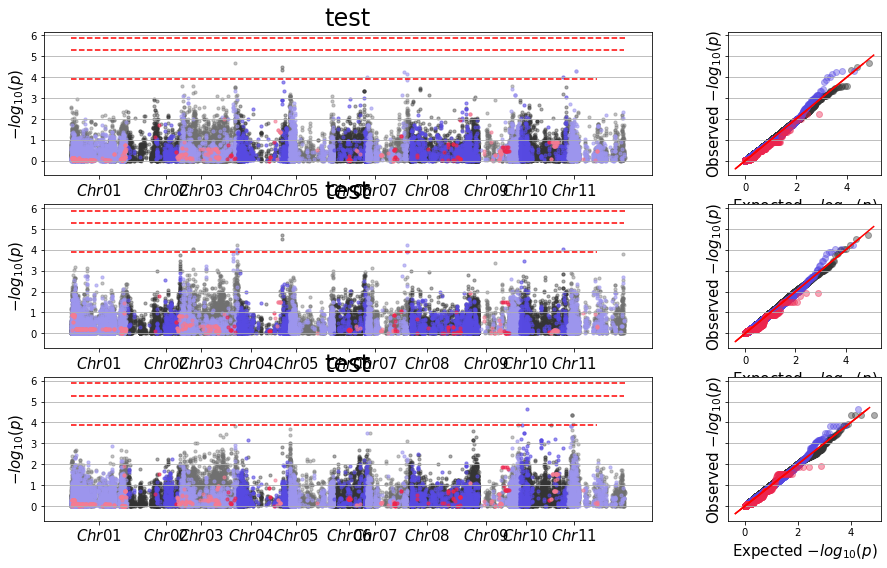

In [76]:
w = 15
for i, sdf_var in GWAS_df.groupby('var'):
    nEnvs = len(sdf_var.Location.unique())
    h = 3*nEnvs
    fig, axs = plt.subplots(ncols=2, nrows=nEnvs,gridspec_kw={'width_ratios': [4, 1]},sharey=True,figsize=(w,h))
    row = 0
    for j, sdf_location in sdf_var.groupby('Location'):
        for k, sdf_source in sdf_location.groupby('source'):
            get_ManhattanPot_pair(sdf_source, axs[row], 'test', colors=plot_params[k][0], alpha=plot_params[k][1], size=plot_params[k][2])
        row += 1
        
    break
    

In [59]:
axs[0]

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)